In [1]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque, defaultdict
from itertools import count
import itertools
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd

# Board Methods

The board will be represented as a 3D array, where each array is a column state, and each token in the column is a 2-item list. The first item is the level the token is on (-1 if the token has been removed) and the second item is whether remover has just selected the token. Also within the list, a token always keeps its position within the column.

Example(board started out with 3 columns and 2 tokens per column): 

<img src="images/ex2.png" width="200">

Representation: [[[2, 0], [1, 1]], [[0, 0], [3, 1]], [[-1, 0], [-1, 0]]]

score_board Method:

This method scores a given board state, crucial for giving feedback to pusher and remover neural network. Right now the scoring method using an exponential model for scoring based on the number of columns times the number of tokens. That way, as an end result, Pusher is incentived to get a token as high up as possible as their main goal as opposed to many tokens at a lower level. However, for now there are drawbacks to this as this could cause pusher to think too much in the short term.

In [2]:
class Board():
    def __init__(self, n, k):
        self.board = {}
        self.selected = {}
        for i in range(n):
            self.board[i] = [[0, 0] for j in range(k)] #level, selected:
            #-1 if removed, 0 if not selected, 1 if selected
        self.n = n
        self.k = k
        self.max_score = 0
        
    def score_board(self, isRemover):
        score = 1
        val = self.n * self.k
        for i in range(self.n):
            for level, sel in self.board[i]:
                if level >= 0:
                    score += pow(val, level)
                else:
                    score += 0
        score = math.log(score, val)
        if isRemover:
            return -1 * score
        return score
    
    def game_over(self):
        for i in range(self.n):
            for level, sel in self.board[i]:
                if level != -1:
                    return False
        return True
    
    def index(self, index):
        return [int(index/self.k), self.board[int(index/self.k)][index % self.k][0]]
    
    def __str__(self): #Prints the board out in a neat fashion
        ans = ""
        for i in range(self.n):
            ans += f"Column {i}: {self.board[i]}\n"
        return ans
    
def board_to_remover(state): #Converts the board state into a list of numbers to be fed into remover neural network
    n = len(state.board)
    k = len(state.board[0])
    ans = [n, k]
    for i in range(n):
        temp = state.board[i]
        for level, sel in temp:
            ans.append(level)
            ans.append(sel)
    return ans

def board_to_pusher(state): #Converts the board state into a list of numbers to be fed into pusher neural network
    n = len(state.board)
    k = len(state.board[0])
    ans = [n, k]
    for i in range(n):
        temp = state.board[i]
        for level, sel in temp:
            ans.append(level)
    return ans

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'state_poss', 'next_state_poss'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Neural Network Method

In [3]:
class Pusher_DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(Pusher_DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 512)
        self.layer3 = nn.Linear(512, 668)
        self.layer4 = nn.Linear(668, 324)
        self.layer5 = nn.Linear(324, 128)
        self.layer6 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
        return self.layer6(x)
    
    
class Remover_DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(Remover_DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 312)
        self.layer3 = nn.Linear(312, 498)
        self.layer4 = nn.Linear(498, 212)
        self.layer5 = nn.Linear(212, 128)
        self.layer6 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
        return self.layer6(x)

# Pusher Methods

In [4]:
subset_graph = {}
num_graph = {}
#structure will be subset_graph[num] = subset
#strucutre of num_graph will be num_graph[subset] = num

#Helper method for getting pushers possible moves
def get_subset_nums(state, subsets): #Given subsets, gets all the index numbers of these subsets
    poss = []
    visited = set()
    for subset in subsets:
        val = []
        for item in subset:
            val.extend(state.index(item))
        if tuple(val) not in visited:
            poss.append(num_graph[tuple(subset)])
            visited.add(tuple(val))
    return poss


#Helper method for getting pushers possible moves
def get_subset(state, num):#Given a subset number, gets the subset
    return subset_graph[num]


def is_possible_push(state):#Gets all the possible moves for the pusher
    indices = []
    index = 0
    for i in range(state.n):
        for level, sel in state.board[i]:
            if level != -1:
                indices.append(index)
            index += 1
    subsets = []
    for i in range(1, len(indices) + 1):
        for subset in itertools.combinations(indices, i):
            subsets.append(subset)
    return get_subset_nums(state, subsets)

def select_pusher_move(state, policy_net, isRandom=False): #Selects an action for pusher given a model
    num_state = board_to_pusher(state)
    input_tensor = torch.tensor(num_state, device=device, dtype=torch.float32)
    output = policy_net(input_tensor)
    poss = is_possible_push(state)
    if not isRandom:
        selected = output[poss]
        max_index_subset = torch.argmax(selected)
        max_index_original = poss[max_index_subset]
        return torch.tensor(max_index_original, dtype=torch.int64), poss
    if isRandom:
        return torch.tensor(random.choice(poss), dtype=torch.int64), poss
    
def make_move_pusher(state, pusher_net=None, bound=0):
    '''
    Makes a move given a pusher neural network. If no network given, then move is random.
    Bound variable is used to add randomness to the process if given a network, if bound is 0 that means no randomness. 
    '''
    random_number = random.random()
    if pusher_net != None and random_number >= bound:
        num_state = board_to_pusher(state)
        input_tensor = torch.tensor(num_state, device=device, dtype=torch.float32)
        output = pusher_net(input_tensor)
        poss = is_possible_push(state)
        selected = output[poss]
        max_index_subset = torch.argmax(selected)
        action = poss[max_index_subset]
        subset = get_subset(state, action)
        index = 0
        for i in range(state.n):
            for j in range(state.k):
                if index in subset and state.board[i][j][0] != -1:
                    state.board[i][j][1] = 1
                    state.board[i][j][0] += 1
                    state.max_score = max(state.max_score, state.board[i][j][0])
                index += 1
        return state
    else:
        poss = is_possible_push(state)
        action = random.choice(poss)
        subset = get_subset(state, action)
        index = 0
        for i in range(state.n):
            for j in range(state.k):
                if index in subset and state.board[i][j][0] != -1:
                    state.board[i][j][1] = 1
                    state.board[i][j][0] += 1
                    state.max_score = max(state.max_score, state.board[i][j][0])
                index += 1
        return state
    
def make_move_pusher_action(state, action): #Pusher makes a move given an action
    subset = get_subset(state, action)
    index = 0
    for i in range(state.n):
        for j in range(state.k):
            if index in subset and state.board[i][j][0] != -1:
                state.board[i][j][1] = 1
                state.board[i][j][0] += 1
                state.max_score = max(state.max_score, state.board[i][j][0])
            index += 1
    return state

def select_action_pusher(state, policy_net, EPS_START, EPS_END, EPS_DECAY, steps_done): #Selects an action for the pusher in training
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return select_pusher_move(state, policy_net, isRandom=False)
    else:
        return select_pusher_move(state, policy_net, isRandom=True)

# Remover Methods

In [5]:
def is_possible_remove(state): #Given a state, gets all the possible moves for the remover
    poss = []
    for i in range(state.n):
        for label, sel in state.board[i]:
            if sel == 1:
                poss.append(i)
                break
    return poss

def make_move_remover(state, remover_net=None, bound=0):#uses the current remover net to make a move for the remover, otherwise it goes random
    random_number = random.random()
    if remover_net != None and random_number > bound:
        inp = torch.tensor(board_to_remover(state), device=device, dtype=torch.float32)
        output = remover_net(inp)
        poss = is_possible_remove(state)
        action = -1
        if len(poss) == 0:
            action = 0
        else:
            selected = output[poss]
            max_index_subset = torch.argmax(selected)
            max_index_original = poss[max_index_subset]
            action = int(max_index_original)
        for j in range(state.k):
            if state.board[action][j][1] == 1:
                state.board[action][j][0] = -1
        for i in range(state.n):
            for j in range(state.k):
                state.board[i][j][1] = 0
        return state
    else:
        poss = is_possible_remove(state)
        action = -1
        if len(poss) == 0:
            action = 0
        action = random.choice(poss)
        for j in range(state.k):
            if state.board[action][j][1] == 1:
                state.board[action][j][0] = -1
        for i in range(state.n):
            for j in range(state.k):
                state.board[i][j][1] = 0
        return state
    
def make_move_remover_action(state, action): #make move to remover given an action
    action = int(action)
    for j in range(state.k):
        if state.board[action][j][1] == 1:
            state.board[action][j][0] = -1
    for i in range(state.n):
        for j in range(state.k):
            state.board[i][j][1] = 0
    return state
    
    
def select_remover_move(state, policy_net, isRandom=False): #Selects an action for remover given a model
    num_state = board_to_remover(state)
    input_tensor = torch.tensor(num_state, device=device, dtype=torch.float32)
    output = policy_net(input_tensor)
    poss = is_possible_remove(state)
    if not isRandom:
        selected = output[poss]
        max_index_subset = torch.argmax(selected)
        max_index_original = poss[max_index_subset]
        return torch.tensor(max_index_original, dtype=torch.int64), poss
    if isRandom:
        return torch.tensor(random.choice(poss), dtype=torch.int64), poss
    
def select_action_remover(state, policy_net, EPS_START, EPS_END, EPS_DECAY, steps_done): #Select Action for training
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return select_remover_move(state, policy_net, isRandom=False)
    else:
        return select_remover_move(state, policy_net, isRandom=True)

# General Board Methods

In [6]:
def sim_game(n, k, pusher_net, remover_net):#Simulates a game, printing board state along the way
    state = Board(n, k)
    while state.game_over() == False:
        state = make_move_pusher(state, pusher_net)
        print("Pusher's move: ")
        print(state)
        state = make_move_remover(state, remover_net)
        print("Remover's move: ")
        print(state)
        print()
    print("GAME OVER")
    print(f"Pusher's Max Score: {state.max_score}")
    return state.max_score

def sim_game_no_print(n, k, pusher_net, remover_net):#Simulates the game without printing the board state
    state = Board(n, k)
    while state.game_over() == False:
        state = make_move_pusher(state, pusher_net)
        state = make_move_remover(state, remover_net)
    return state.max_score

In [7]:
def optimize_model(policy_net, target_net, optimizer, memory):#Training step for the model
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))


    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state
                                                if s is not None])

    non_final_next_poss = [s for s in batch.next_state_poss
                          if s is not None]

    state_batch = torch.stack(batch.state)
    reshaped_action = [t.unsqueeze(0) for t in batch.action]
    action_batch = torch.stack(reshaped_action)
    reward_batch = torch.stack(batch.reward)


    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        target_net_output = target_net(non_final_next_states)

        # Iterate over each row in the output and the corresponding indices
        indx = 0 
        for i in range(BATCH_SIZE):
            if non_final_mask[i]:
                # Extract the values at the specified indices for this row
                indices = non_final_next_poss[indx]
                selected_values = target_net_output[indx, indices]

                # Find the maximum value among the selected values
                max_value = selected_values.max()

                # Assign the max value to next_state_values
                next_state_values[i] = max_value
                indx += 1


    next_state_values = next_state_values.unsqueeze(1)
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

# Training Model!

Episode 0 Complete!
Episode 50 Complete!
Episode 100 Complete!
Episode 150 Complete!
Episode 200 Complete!
Episode 250 Complete!
Episode 300 Complete!
Episode 350 Complete!
Episode 400 Complete!
Episode 450 Complete!
Episode 500 Complete!
Episode 550 Complete!
Episode 600 Complete!
Episode 650 Complete!
Episode 700 Complete!
Episode 750 Complete!
Episode 800 Complete!
Episode 850 Complete!
Episode 900 Complete!
Episode 950 Complete!
remover Complete on Episode 999


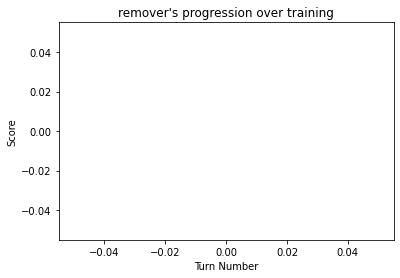

CURRENT SCORE: -1
Episode 0 Complete!
Episode 50 Complete!
Episode 100 Complete!
Episode 150 Complete!
Episode 200 Complete!
Episode 250 Complete!
Episode 300 Complete!
Episode 350 Complete!
Episode 400 Complete!
Episode 450 Complete!
Episode 500 Complete!
Episode 550 Complete!
Episode 600 Complete!
Episode 650 Complete!
Episode 700 Complete!
Episode 750 Complete!
Episode 800 Complete!
Episode 850 Complete!
Episode 900 Complete!
Episode 950 Complete!
pusher Complete on Episode 999


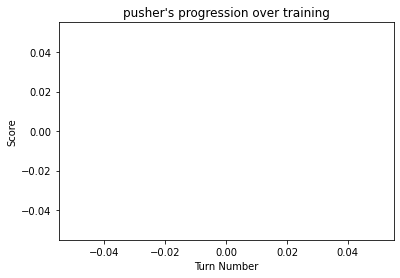

pusher Complete
CURRENT SCORE: -1
Episode 0 Complete!
remover Complete on Episode 50


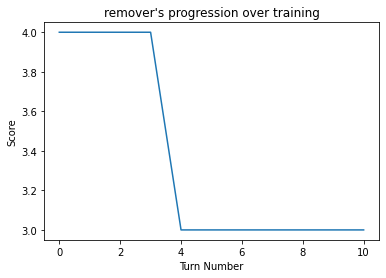

Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [1, 1], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[2, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [1, 1]]

Remover's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[2, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [1, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 1], [1, 1], [1, 1]]
Level 1: [[3, 1], [1, 1], [1, 1], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [2, 1]]

Remover's move: 
Level 0: [[-1, 0], [1, 0], [1, 0], [1, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [2, 0]]


Pusher's move: 
Level 0: [[-1, 0], [2, 1], [1, 0], [1, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [1, 1]]
Level 2: [[

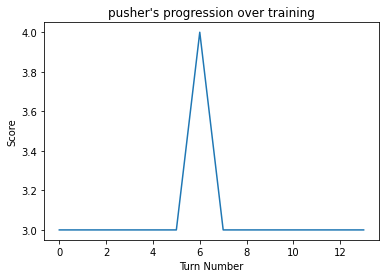

pusher Complete
Pusher's move: 
Level 0: [[0, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[0, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[0, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[0, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [1, 1], [1, 1], [0, 0]]
Level 2: [[-1, 0], [1, 1], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 0], [1, 1], [1, 1], [0, 0]]
Level 1: [[2, 1], [1, 0], [1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [1, 0], [1, 0], [0, 0]]
Level 1: [[-1, 0], [1, 0], [1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 0], [1, 0], [1, 0], [1, 1]]
Level 1: [[-1, 0], [2, 1], [1, 0], [0, 0]]
Level 2

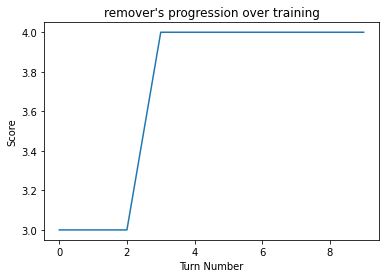

Pusher's move: 
Level 0: [[0, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[0, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[0, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[0, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [1, 1], [1, 1], [0, 0]]
Level 2: [[-1, 0], [1, 1], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [0, 0]]
Level 2: [[-1, 0], [1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 0], [1, 1], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [0, 0]]
Level 2: [[-1, 0], [1, 0], [1, 0], [1, 1]]

Remover's move: 
Level 0: [[1, 0], [-1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [0, 0]]
Level 2: [[-1, 0], [1, 0], [1, 0], [1, 0]]


Pusher's move: 
Level 0: [[1, 0], [-1, 0], [1, 1], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [1, 1]]
Level 2: [[-1, 0]

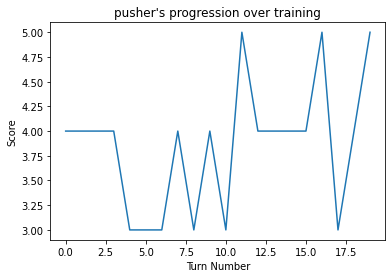

pusher Complete
Pusher's move: 
Level 0: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 1: [[1, 1], [1, 1], [1, 1], [0, 0]]
Level 2: [[1, 1], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [1, 0], [0, 0], [0, 0]]
Level 1: [[2, 1], [1, 0], [1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[2, 0], [1, 0], [1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[2, 0], [2, 1], [1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [2, 1], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[2, 0], [2, 0], [1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 0], [1, 1], [1, 1]]
Level 1: [[2, 0], [2, 0], [1, 0], [1, 1]]
Level

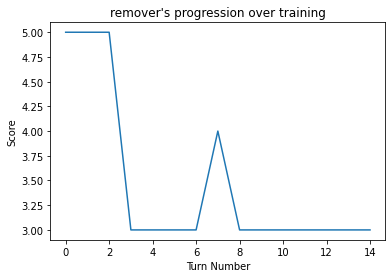

Pusher's move: 
Level 0: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 1: [[1, 1], [1, 1], [1, 1], [0, 0]]
Level 2: [[1, 1], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [0, 0]]
Level 2: [[1, 0], [1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [1, 1]]
Level 2: [[2, 1], [1, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [1, 0]]
Level 2: [[-1, 0], [1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 0], [1, 0], [1, 1], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [2, 1]]
Level 2: [[-1, 0], [2, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [1, 0], [1, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [-1, 0]]
Level 2: [[-1, 0], [2, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [1, 0], [1, 0], [1, 1]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [-1, 0]]
Level 2: [[-1

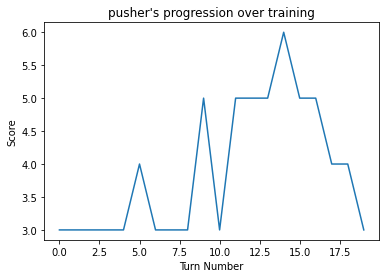

pusher Complete
Pusher's move: 
Level 0: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 1: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 2: [[1, 1], [1, 1], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [1, 1], [1, 1]]
Level 1: [[1, 0], [1, 0], [1, 1], [1, 1]]
Level 2: [[2, 1], [2, 1], [2, 1], [1, 1]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [1, 0], [1, 0]]
Level 1: [[1, 0], [1, 0], [1, 0], [1, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [-1, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [2, 1], [1, 0]]
Level 1: [[2, 1], [1, 0], [1, 0], [1, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [-1, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [2, 0], [1, 0]]
Level 1: [[-1, 0], [1, 0], [1, 0], [1, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [-1, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [3, 1], [1, 0]]
Level 1: [[-1, 0], [2, 1], [1, 0], [1

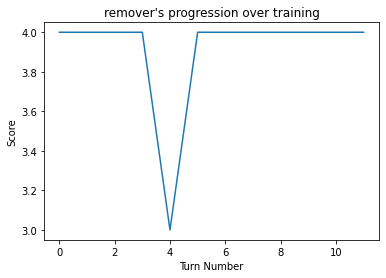

Pusher's move: 
Level 0: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 1: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 2: [[1, 1], [1, 1], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [1, 1], [1, 1]]
Level 1: [[1, 0], [1, 0], [1, 1], [1, 1]]
Level 2: [[2, 1], [2, 1], [2, 1], [1, 1]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [1, 0], [1, 0]]
Level 1: [[1, 0], [1, 0], [1, 0], [1, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [-1, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [2, 1], [1, 0]]
Level 1: [[2, 1], [1, 0], [1, 0], [1, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [-1, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [2, 0], [1, 0]]
Level 1: [[-1, 0], [1, 0], [1, 0], [1, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [-1, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [3, 1], [1, 0]]
Level 1: [[-1, 0], [2, 1], [1, 0], [1, 0]]
Level 2: [

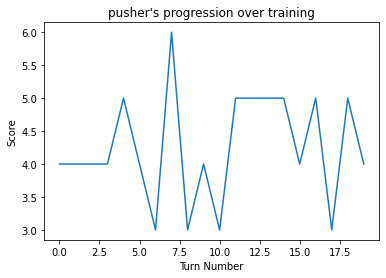

pusher Complete
Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 2: [[1, 1], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [1, 1], [0, 0]]
Level 2: [[1, 0], [1, 0], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [1, 0], [0, 0]]
Level 2: [[1, 0], [1, 0], [-1, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 1], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [1, 0], [1, 1]]
Level 2: [[1, 0], [1, 0], [-1, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [1, 0], [1, 0]]
Level 2: [[1, 0], [1, 0], [-1, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [1, 1], [0, 0]]
Level 1: [[2, 1], [1, 0], [1, 0], [1, 0]]
Level 2: 

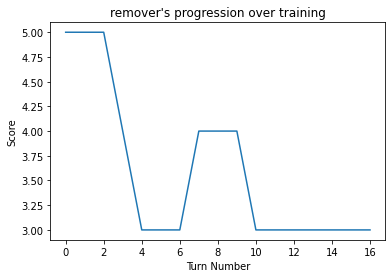

Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 2: [[1, 1], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [1, 1], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [-1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [1, 1], [1, 1], [1, 1]]
Level 1: [[2, 1], [2, 1], [-1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [2, 1], [1, 1]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [-1, 0], [-1, 0]]
Level 1: [[2, 0], [2, 0], [-1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [2, 0], [1, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [-1, 0], [-1, 0]]
Level 1: [[2, 0], [2, 0], [-1, 0], [1, 1]]
Level 2: [[-1,

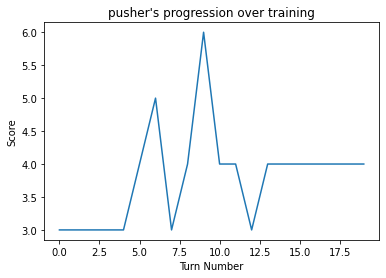

pusher Complete
Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[0, 0], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[0, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 1], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [-1, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 1], [1, 1], [0, 0]]
Level 1: [[1, 0], [-1, 0], [1, 1], [0, 0]]
Level 2: [[2, 1], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [1, 0], [1, 0], [0, 0]]
Level 1: [[1, 0], [-1, 0], [-1, 0], [0, 0]]
Level 2: [[2, 0], [1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 0], [1, 0], [1, 1]]
Level 1: [[2, 1], [-1, 0], [-1, 0], [0, 0]]
Level 2:

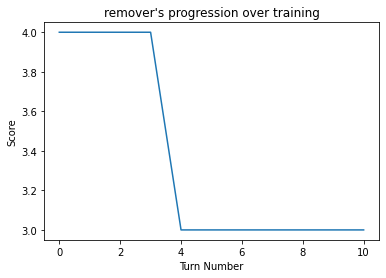

Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[0, 0], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[0, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [1, 1], [0, 0], [0, 0]]
Level 2: [[0, 0], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[0, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 1], [1, 1], [0, 0]]
Level 1: [[-1, 0], [1, 0], [1, 1], [0, 0]]
Level 2: [[1, 1], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [1, 0], [1, 0], [0, 0]]
Level 1: [[-1, 0], [1, 0], [1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [2, 1], [2, 1], [1, 1]]
Level 1: [[-1, 0], [1, 0], [1, 0], [1, 1]]
Level 2: [[-1, 0], [-1, 

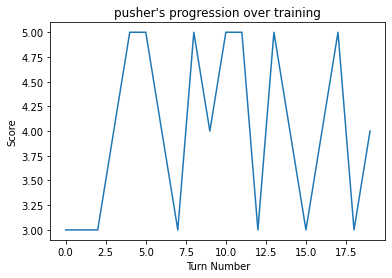

pusher Complete
Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [1, 1], [1, 1], [0, 0]]
Level 2: [[1, 1], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 1], [0, 0], [0, 0]]
Level 1: [[2, 1], [1, 0], [1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [1, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [1, 0], [1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [2, 1], [0, 0], [0, 0]]
Level 1: [[-1, 0], [1, 0], [1, 0], [1, 1]]
Leve

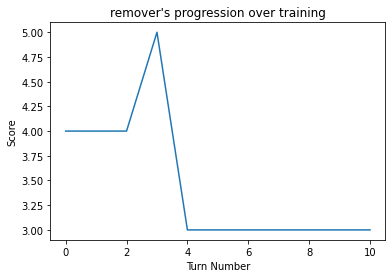

Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [1, 1], [1, 1], [0, 0]]
Level 2: [[1, 1], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [0, 0]]
Level 2: [[1, 0], [1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [1, 1], [1, 1], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [1, 1]]
Level 2: [[2, 1], [1, 0], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [-1, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [1, 0]]
Level 2: [[2, 0], [1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [-1, 0], [1, 1]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [1, 0]]
Level 2: [[3, 1], [1, 0], [1, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [-1, 0], [1, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [1, 0]]
Level 2: [[-1, 0], [1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [-1, 0], [2, 1]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [1, 0]]
Level

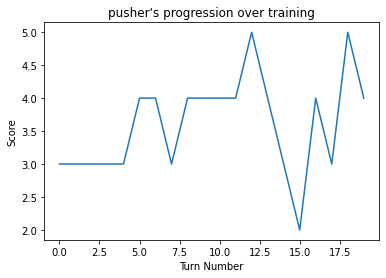

pusher Complete
Pusher's move: 
Level 0: [[0, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[0, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [1, 1], [0, 0], [0, 0]]
Level 2: [[1, 0], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [2, 1], [0, 0], [0, 0]]
Level 2: [[1, 0], [1, 0], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [2, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [1, 0], [-1, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 1], [1, 1], [0, 0]]
Level 1: [[-1, 0], [2, 0], [0, 0], [0, 0]]
Level 2: 

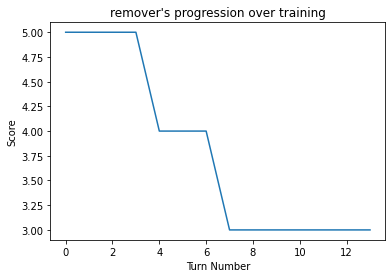

Pusher's move: 
Level 0: [[0, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[0, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [1, 1], [0, 0], [0, 0]]
Level 2: [[1, 0], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [-1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [1, 0], [1, 1], [0, 0]]
Level 2: [[2, 1], [-1, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[2, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [1, 0], [1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[3, 1], [1, 1], [1, 1], [1, 1]]
Level 1: [[-1, 0], [2, 1], [1, 0], [1, 1]]
Level 2: [[-1, 0], [-1, 0]

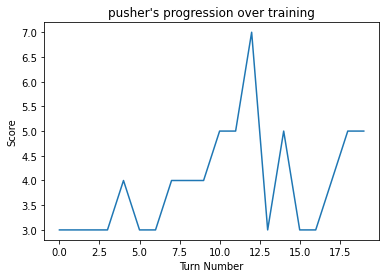

pusher Complete
Pusher's move: 
Level 0: [[0, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[0, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [1, 1], [0, 0], [0, 0]]
Level 2: [[1, 0], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [-1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [1, 1], [0, 0], [0, 0]]
Level 1: [[-1, 0], [2, 1], [0, 0], [0, 0]]
Level 2: [[1, 0], [-1, 0], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[2, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [2, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [-1, 0], [-1, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 0], [1, 0], [1, 1], [0, 0]]
Level 1: [[-1, 0], [2, 0], [1, 1], [0, 0]]
Level 2: [

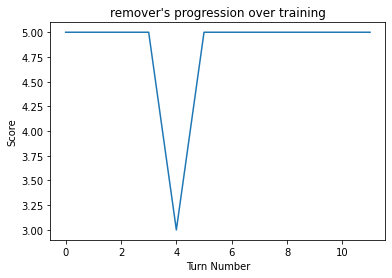

Pusher's move: 
Level 0: [[0, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[0, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 1], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [-1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [-1, 0], [1, 1], [1, 1]]
Level 2: [[-1, 0], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [-1, 0], [-1, 0], [-1, 0]]
Level 2: [[-1, 0], [1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [1, 1], [0, 0], [0, 0]]
Level 1: [[2, 1], [-1, 0], [-1, 0], [-1, 0]]
Level 2: [[-1, 0], [1, 

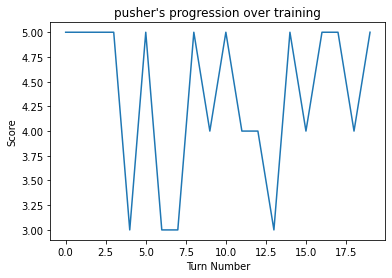

pusher Complete
Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 1], [1, 1], [0, 0]]
Level 2: [[-1, 0], [1, 1], [1, 1], [1, 1]]

Remover's move: 
Level 0: [[2, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [-1, 0], [-1, 0], [0, 0]]
Level 2: [[-1, 0], [1, 0], [1, 0], [1, 0]]


Pusher's move: 
Level 0: [[3, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [-1, 0], [-1, 0], [1, 1]]
Level 2: [[-1, 0], [2, 1], [2, 1], [1, 0]]

Remover's move: 
Level 0: [[3, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [-1, 0], [-1, 0], [-1, 0]]
Level 2: [[-1, 0], [2, 0], [2, 0], [1, 0]]


Pusher's move: 
Level 0: [[4, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[2, 1], [-1, 0], [-1, 0], [-1, 0]]
Level

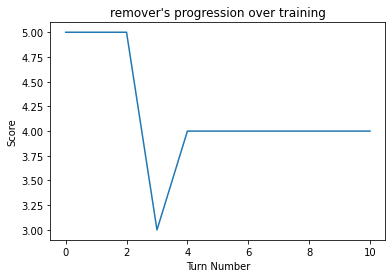

Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 1], [1, 1], [0, 0]]
Level 2: [[-1, 0], [1, 1], [1, 1], [1, 1]]

Remover's move: 
Level 0: [[2, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [-1, 0]]


Pusher's move: 
Level 0: [[3, 1], [1, 1], [1, 1], [0, 0]]
Level 1: [[2, 1], [2, 1], [2, 1], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [-1, 0]]

Remover's move: 
Level 0: [[3, 0], [1, 0], [1, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [-1, 0]]


Pusher's move: 
Level 0: [[4, 1], [2, 1], [2, 1], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [1, 1]]
Level 2: [[-1, 0

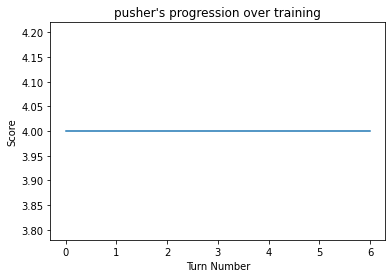

pusher Complete
Pusher's move: 
Level 0: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 1: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 2: [[0, 0], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[0, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [1, 1], [0, 0]]
Level 1: [[2, 1], [1, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [1, 0], [0, 0]]
Level 1: [[2, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [1, 0], [1, 1]]
Level 1: [[3, 1], [2, 1], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [1, 1], [1, 1]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [1, 0], [1, 0]]
Level 1: [[-1, 0], [-1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [1, 0], [1, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [2, 1], [1, 0]]
Level 1: [[-1, 0], [-1, 0], [1, 1], [0, 0]

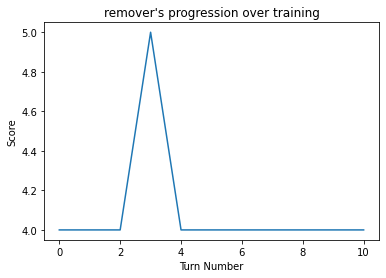

Pusher's move: 
Level 0: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 1: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 2: [[0, 0], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[0, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [1, 1], [0, 0]]
Level 1: [[2, 1], [1, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [1, 0], [0, 0]]
Level 1: [[2, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [1, 0], [1, 1]]
Level 1: [[3, 1], [2, 1], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [1, 1], [1, 1]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [1, 0], [1, 0]]
Level 1: [[3, 0], [2, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [-1, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [1, 0], [1, 0]]
Level 1: [[3, 0], [3, 1], [0, 0], [0, 0]]
Level 2: [[-1, 0

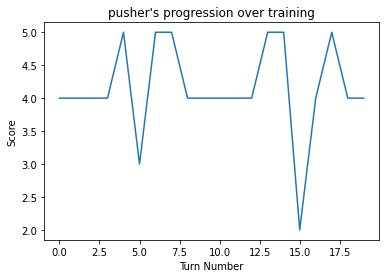

pusher Complete
Pusher's move: 
Level 0: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 1: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 2: [[1, 1], [1, 1], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [1, 1], [0, 0]]
Level 1: [[1, 0], [1, 0], [1, 1], [0, 0]]
Level 2: [[2, 1], [1, 0], [1, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [1, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [1, 0], [0, 0]]
Level 2: [[-1, 0], [1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [2, 1], [0, 0]]
Level 1: [[1, 0], [1, 0], [1, 0], [1, 1]]
Level 2: [[-1, 0], [2, 1], [2, 1], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [2, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [1, 0], [-1, 0]]
Level 2: [[-1, 0], [2, 0], [2, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [2, 0], [1, 1]]
Level 1: [[2, 1], [1, 0], [1, 0], [-1, 0]]
Lev

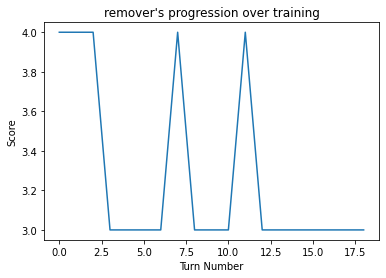

Pusher's move: 
Level 0: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 1: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 2: [[1, 1], [1, 1], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 0], [1, 0], [1, 1], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [1, 1], [0, 0]]
Level 2: [[2, 1], [1, 0], [1, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [1, 0], [1, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [1, 0], [0, 0]]
Level 2: [[-1, 0], [1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 0], [1, 0], [1, 0], [1, 1]]
Level 1: [[-1, 0], [-1, 0], [2, 1], [1, 1]]
Level 2: [[-1, 0], [1, 0], [1, 0], [1, 1]]

Remover's move: 
Level 0: [[1, 0], [1, 0], [1, 0], [1, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [-1, 0]]
Level 2: [[-1, 0], [1, 0], [1, 0], [1, 0]]


Pusher's move: 
Level 0: [[2, 1], [2, 1], [1, 0], [1, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [-1, 0]]
Level 2: [[-1, 0]

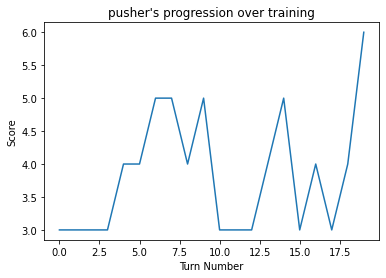

pusher Complete
Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[0, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[0, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 0], [1, 1], [0, 0], [0, 0]]
Level 1: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [1, 0], [0, 0], [0, 0]]
Level 1: [[2, 1], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [1, 1]]

Remover's move: 
Level 0: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[2, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [1, 0]]


Pusher's move: 
Level 0: [[-1, 0], [2, 1], [0, 0], [0, 0]]
Level 1: [[2, 0], [1, 0], [1, 1], [0, 0]]
Level

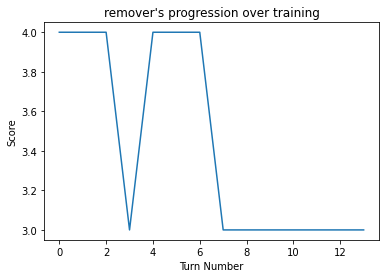

Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[0, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[0, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 0], [1, 1], [0, 0], [0, 0]]
Level 1: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [1, 1], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [1, 0], [1, 1]]

Remover's move: 
Level 0: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [1, 0], [1, 0]]


Pusher's move: 
Level 0: [[2, 1], [1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [0, 0]]
Level 2: [[-1, 0

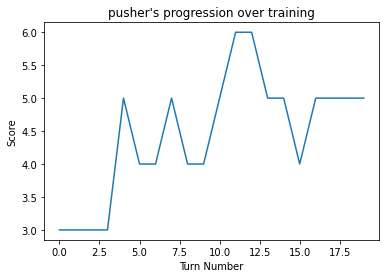

pusher Complete
Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [1, 1], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [1, 1], [1, 1], [0, 0]]
Level 1: [[-1, 0], [1, 1], [1, 1], [0, 0]]
Level 2: [[2, 1], [2, 1], [1, 0], [0, 0]]

Remover's move: 
Level 0: [[2, 0], [1, 0], [1, 0], [0, 0]]
Level 1: [[-1, 0], [1, 0], [1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[3, 1], [1, 0], [1, 0], [0, 0]]
Level 1: [[-1, 0], [2, 1], [1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [1, 0], [1, 1]]

Remover's move: 
Level 0: [[3, 0], [1, 0], [1, 0], [0, 0]]
Level 1: [[-1, 0], [2, 0], [1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [1, 0], [-1, 0]]


Pusher's move: 
Level 0: [[4, 1], [2, 1], [1, 0], [0, 0]]
Level 1: [[-1, 0], [3, 1], [1, 0], [0, 0]]
Level 2

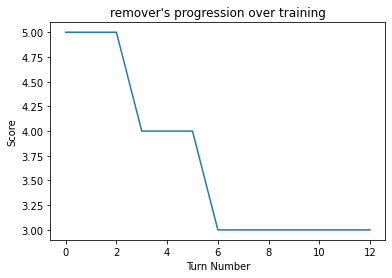

Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [1, 1], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 1], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [1, 1]]

Remover's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [1, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 1], [1, 1], [0, 0]]
Level 1: [[2, 1], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [1, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [-1, 0], [0, 0]]
Level 1: [[2, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [1, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [-1, 0], [0, 0]]
Level 1: [[2, 0], [2, 1], [0, 0], [0, 0]]
Level 2: [[-1

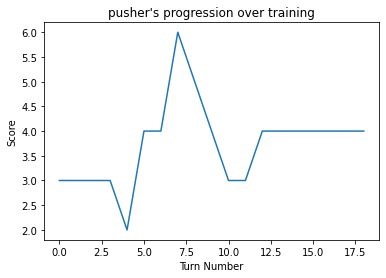

pusher Complete
Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 0], [1, 1], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 0], [1, 0], [1, 1], [0, 0]]
Level 1: [[2, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [1, 0], [-1, 0], [0, 0]]
Level 1: [[2, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [1, 0], [-1, 0], [0, 0]]
Level 1: [[2, 0], [1, 1], [0, 0], [0, 0]]
Level 2: [

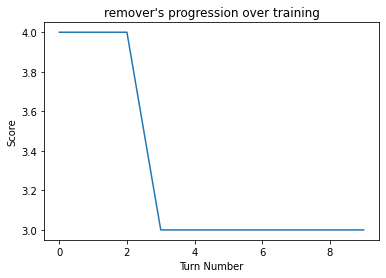

Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[2, 1], [1, 1], [0, 0], [0, 0]]
Level 2: [[2, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [0, 0], [0, 0]]
Level 2: [[2, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 1], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [0, 0], [0, 0]]
Level 2: [[2, 0], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [0, 0], [0, 0]]
Level 2: [[2, 0], [-1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 0], [1, 1], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [1, 1], [0, 0]]
Level 2: [[2, 0], [-1

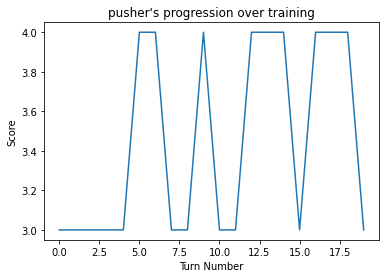

pusher Complete
Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 1], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 1], [0, 0], [0, 0]]
Level 2: [[2, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [2, 1], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [1, 1], [1, 1]]
Level 2: [[-1, 0], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [2, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [1, 0], [1, 0]]
Level 2: [[-1, 0], [-1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [3, 1], [1, 1], [1, 1]]
Level 1: [[2, 1], [1, 0], [1, 0], [1, 0]]
Level 2: [

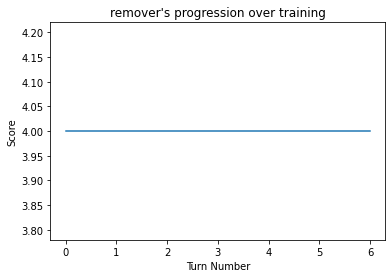

Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 1], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 1], [0, 0], [0, 0]]
Level 2: [[2, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [2, 1], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [1, 1], [1, 1]]
Level 2: [[-1, 0], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [2, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [1, 0], [1, 0]]
Level 2: [[-1, 0], [-1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [3, 1], [1, 1], [1, 1]]
Level 1: [[2, 1], [1, 0], [1, 0], [1, 0]]
Level 2: [[-1, 0], [-1, 0]

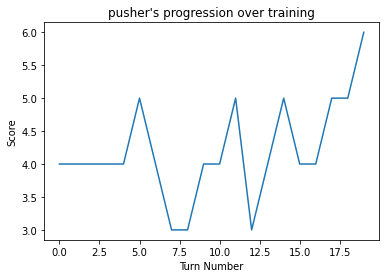

pusher Complete
Pusher's move: 
Level 0: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 1: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [1, 0], [0, 0], [0, 0]]
Level 1: [[2, 1], [1, 0], [1, 1], [0, 0]]
Level 2: [[-1, 0], [1, 1], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[2, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [1, 0], [-1, 0], [0, 0]]
Level 2: [[-1, 0], [1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[3, 1], [1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [2, 1], [-1, 0], [0, 0]]
Level 2: [[-1, 0], [1, 0], [1, 0], [1, 1]]

Remover's move: 
Level 0: [[3, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [2, 0], [-1, 0], [0, 0]]
Level 2: [[-1, 0], [1, 0], [1, 0], [-1, 0]]


Pusher's move: 
Level 0: [[3, 0], [1, 0], [1, 1], [0, 0]]
Level 1: [[-1, 0], [2, 0], [-1, 0], [1, 1]]
Level 

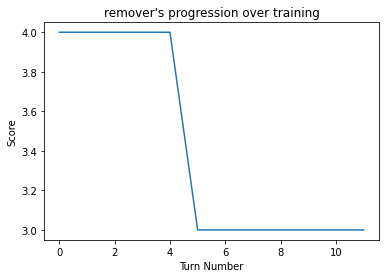

Pusher's move: 
Level 0: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 1: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [1, 1], [1, 1]]
Level 1: [[2, 1], [2, 1], [0, 0], [0, 0]]
Level 2: [[1, 0], [1, 1], [1, 1], [1, 1]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [1, 0], [1, 0]]
Level 1: [[2, 0], [2, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [-1, 0], [-1, 0], [-1, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [2, 1], [1, 0]]
Level 1: [[2, 0], [2, 0], [1, 1], [0, 0]]
Level 2: [[2, 1], [-1, 0], [-1, 0], [-1, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [2, 0], [1, 0]]
Level 1: [[2, 0], [2, 0], [1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [-1, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [3, 1], [1, 0]]
Level 1: [[2, 0], [2, 0], [1, 0], [0, 0]]
Level 2: [[-1,

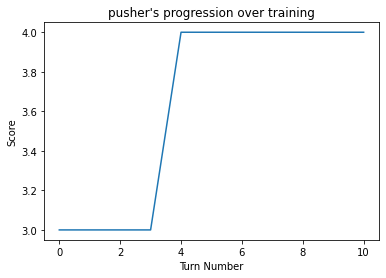

pusher Complete
Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 1], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 1], [0, 0], [0, 0]]
Level 2: [[2, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 0], [1, 1], [0, 0]]
Level 1: [[2, 1], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [1, 0], [-1, 0], [0, 0]]
Level 1: [[2, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 0], [-1, 0], [1, 1]]
Level 1: [[2, 0], [2, 1], [0, 0], [0, 0]]
Level 2: 

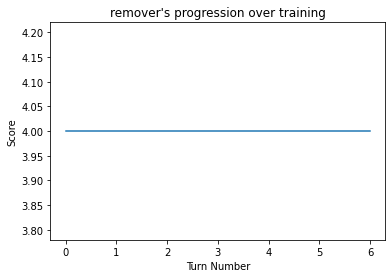

Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 1], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 1], [0, 0], [0, 0]]
Level 2: [[2, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 0], [1, 1], [0, 0]]
Level 1: [[2, 1], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [1, 0], [1, 0], [0, 0]]
Level 1: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 0], [1, 0], [1, 1]]
Level 1: [[-1, 0], [2, 1], [1, 1], [0, 0]]
Level 2: [[-1, 0], [1, 1]

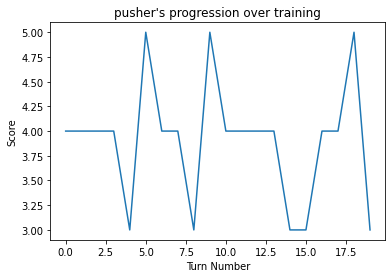

pusher Complete
Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 1], [0, 0], [0, 0]]
Level 2: [[2, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 1], [0, 0], [0, 0]]
Level 1: [[2, 1], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [1, 1], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [1, 0], [1, 1], [0, 0]]
Level 2: 

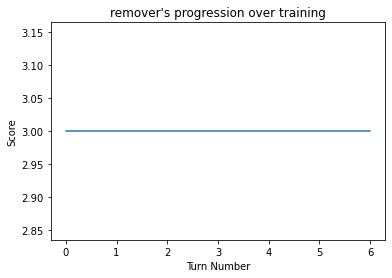

Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 1], [1, 1], [1, 1]]
Level 2: [[-1, 0], [1, 1], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[2, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [-1, 0], [-1, 0], [-1, 0]]
Level 2: [[-1, 0], [1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[2, 1], [-1, 0], [-1, 0], [-1, 0]]
Level 2: [[-1, 0], [2, 1], [1, 0], [0, 0]]

Remover's move: 
Level 0: [[2, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [-1, 0]]
Level 2: [[-1, 0], [2, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [-1, 0]]
Level 2: [[-1, 0]

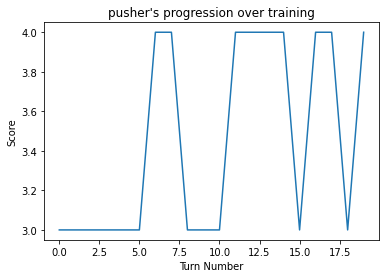

pusher Complete
Pusher's move: 
Level 0: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [1, 0], [0, 0], [0, 0]]
Level 1: [[2, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[2, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [1, 1], [0, 0], [0, 0]]
Level 2: [[-1, 0], [1, 0], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[2, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 0], [1, 0], [1, 1], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [1, 1], [0, 0]]
Level 2: 

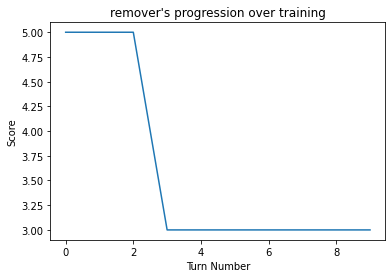

Pusher's move: 
Level 0: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 1], [0, 0], [0, 0]]
Level 2: [[2, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [1, 1], [0, 0]]
Level 1: [[1, 0], [1, 0], [1, 1], [0, 0]]
Level 2: [[-1, 0], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [1, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [2, 1], [0, 0]]
Level 1: [[2, 1], [1, 0], [1, 0], [0, 0]]
Level 2: [[-1, 0], [

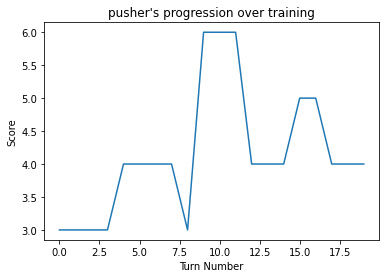

pusher Complete
Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 1], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 1], [0, 0], [0, 0]]
Level 2: [[2, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 0], [1, 1], [1, 1]]
Level 1: [[2, 1], [2, 1], [0, 0], [0, 0]]
Level 2: [[-1, 0], [1, 1], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [1, 0], [1, 0], [1, 0]]
Level 1: [[-1, 0], [-1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 0], [1, 0], [1, 0]]
Level 1: [[-1, 0], [-1, 0], [1, 1], [0, 0]]
Level 2

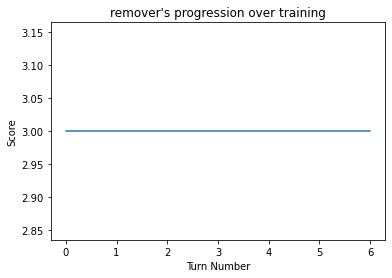

Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 1], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 1], [0, 0], [0, 0]]
Level 2: [[2, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [-1, 0], [0, 0], [0, 0]]
Level 2: [[2, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[2, 1], [-1, 0], [1, 1], [0, 0]]
Level 2: [[3, 1], [1, 1], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[2, 0], [-1, 0], [1, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[2, 0], [-1, 0], [1, 0], [1, 1]]
Level 2: [[-1, 0], [-1,

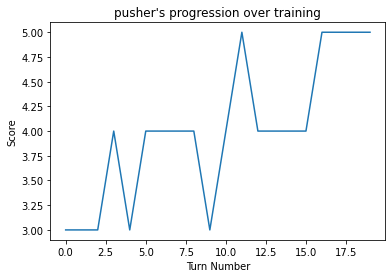

pusher Complete
Pusher's move: 
Level 0: [[1, 1], [1, 1], [1, 1], [0, 0]]
Level 1: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 2: [[1, 1], [1, 1], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [1, 0], [1, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [1, 0], [1, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [1, 1], [0, 0]]
Level 2: [[2, 1], [1, 0], [1, 0], [0, 0]]

Remover's move: 
Level 0: [[2, 0], [1, 0], [1, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [1, 0], [0, 0]]
Level 2: [[-1, 0], [1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 0], [1, 0], [1, 0], [1, 1]]
Level 1: [[-1, 0], [-1, 0], [1, 0], [1, 1]]
Level 2: [[-1, 0], [2, 1], [1, 0], [0, 0]]

Remover's move: 
Level 0: [[2, 0], [1, 0], [1, 0], [1, 0]]
Level 1: [[-1, 0], [-1, 0], [1, 0], [-1, 0]]
Level 2: [[-1, 0], [2, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 0], [1, 0], [1, 0], [1, 0]]
Level 1: [[-1, 0], [-1, 0], [2, 1], [-1, 0]]
Lev

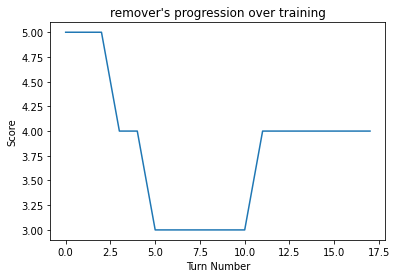

Pusher's move: 
Level 0: [[1, 1], [1, 1], [1, 1], [0, 0]]
Level 1: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 2: [[1, 1], [1, 1], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [1, 0], [1, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [1, 0], [1, 0], [1, 1]]
Level 1: [[2, 1], [2, 1], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [1, 1]]

Remover's move: 
Level 0: [[-1, 0], [1, 0], [1, 0], [-1, 0]]
Level 1: [[2, 0], [2, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [1, 0]]


Pusher's move: 
Level 0: [[-1, 0], [2, 1], [1, 0], [-1, 0]]
Level 1: [[3, 1], [2, 0], [1, 1], [1, 1]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [1, 0]]

Remover's move: 
Level 0: [[-1, 0], [2, 0], [1, 0], [-1, 0]]
Level 1: [[-1, 0], [2, 0], [-1, 0], [-1, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [1, 0]]


Pusher's move: 
Level 0: [[-1, 0], [3, 1], [1, 0], [-1, 0]]
Level 1: [[-1, 0], [3, 1], [-1, 0], [-1, 0]]
Level 2

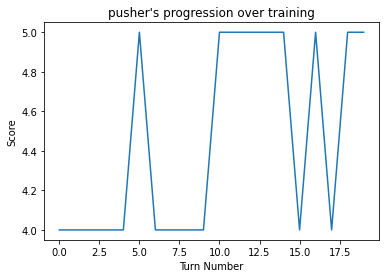

pusher Complete
Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 1], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 1], [1, 1], [0, 0]]
Level 2: [[2, 1], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [-1, 0], [-1, 0], [0, 0]]
Level 2: [[2, 0], [1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [1, 0], [1, 1], [0, 0]]
Level 1: [[2, 1], [-1, 0], [-1, 0], [0, 0]]
Level 2: [[2, 0], [1, 0], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [1, 0], [-1, 0], [0, 0]]
Level 1: [[2, 0], [-1, 0], [-1, 0], [0, 0]]
Level 2: [[2, 0], [1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [2, 1], [-1, 0], [0, 0]]
Level 1: [[3, 1], [-1, 0], [-1, 0], [0, 0]]
Leve

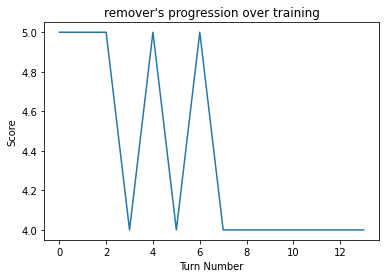

Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 0], [1, 1], [0, 0], [0, 0]]
Level 1: [[-1, 0], [1, 1], [0, 0], [0, 0]]
Level 2: [[2, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [1, 0], [1, 1], [1, 1]]
Level 2: [[-1, 0], [1, 1], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [1, 0], [-1, 0], [-1, 0]]
Level 2: [[-1, 0], [1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 0], [1, 0], [1, 1], [1, 1]]
Level 1: [[-1, 0], [2, 1], [-1, 0], [-1, 0]]
Level 2: [[-1, 0], [1, 

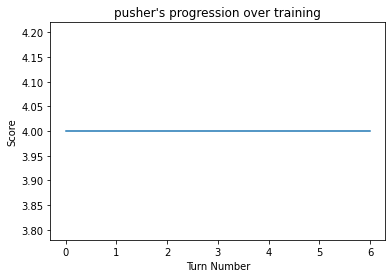

pusher Complete
Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 0], [1, 1], [0, 0], [0, 0]]
Level 1: [[-1, 0], [1, 1], [0, 0], [0, 0]]
Level 2: [[1, 0], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [1, 1], [0, 0]]
Level 2: [[2, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [1, 0], [0, 0]]
Level 2: [[2, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [2, 1], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [2, 1], [0, 0]]
Level 2:

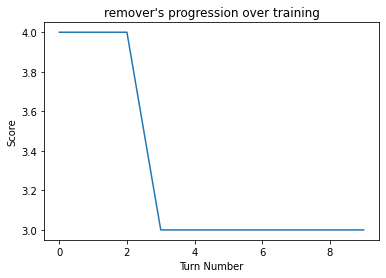

Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[2, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[2, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[2, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [2, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[2, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[2, 0], [1, 1], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0]

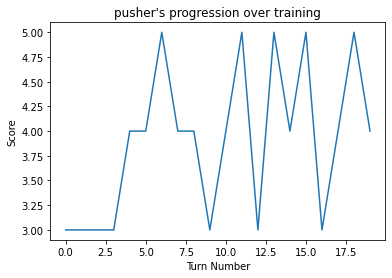

pusher Complete
Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [1, 1], [0, 0], [0, 0]]
Level 1: [[2, 1], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [1, 1], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [0, 0], [0, 0]]
Level 1: [[2, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [1, 1], [0, 0]]
Level 1: [[2, 0], [2, 1], [0, 0], [0, 0]]
Level 2: [[-1, 0], [2, 1], [1, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [1, 0], [0, 0]]
Level 1: [[2, 0], [2, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [1, 0], [1, 1]]
Level 1: [[2, 0], [2, 0], [1, 1], [0, 0]]
Level 

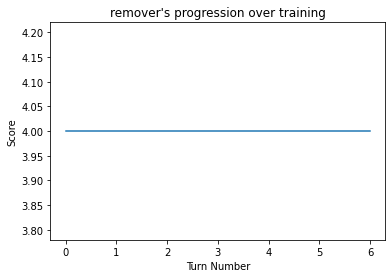

Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [1, 1], [0, 0]]
Level 2: [[2, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[2, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [1, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [2, 1], [0, 0]]
Level 2: [[-1, 0], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[2, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [0, 0]]
Level 2: [[-1, 0], [1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [0, 0]]
Level 2: [[-1, 0], 

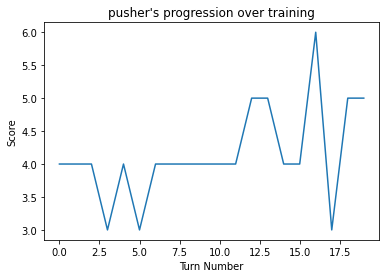

pusher Complete
Pusher's move: 
Level 0: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 0], [1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [1, 1], [0, 0]]
Level 1: [[1, 0], [1, 1], [0, 0], [0, 0]]
Level 2: [[2, 1], [1, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [1, 0], [0, 0]]
Level 1: [[1, 0], [-1, 0], [0, 0], [0, 0]]
Level 2: [[2, 0], [1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [2, 1], [1, 1]]
Level 1: [[2, 1], [-1, 0], [0, 0], [0, 0]]
Level 2: [[3, 1], [1, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [2, 0], [1, 0]]
Level 1: [[-1, 0], [-1, 0], [0, 0], [0, 0]]
Level 2: [[3, 0], [1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [2, 0], [2, 1]]
Level 1: [[-1, 0], [-1, 0], [1, 1], [0, 0]]
Le

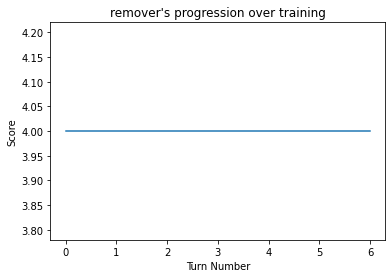

Pusher's move: 
Level 0: [[1, 1], [1, 1], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 0], [1, 0], [1, 1], [1, 1]]
Level 1: [[1, 0], [1, 1], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [1, 1]]

Remover's move: 
Level 0: [[1, 0], [1, 0], [-1, 0], [-1, 0]]
Level 1: [[1, 0], [1, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [1, 0]]


Pusher's move: 
Level 0: [[2, 1], [1, 0], [-1, 0], [-1, 0]]
Level 1: [[1, 0], [1, 0], [1, 1], [0, 0]]
Level 2: [[-1, 0], 

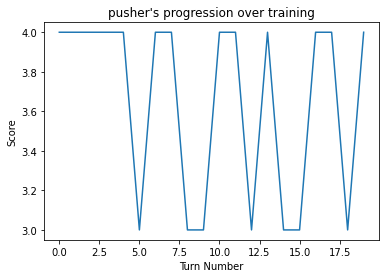

pusher Complete
Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 0], [1, 1], [1, 1], [0, 0]]
Level 1: [[2, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [1, 1], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [1, 0], [1, 0], [0, 0]]
Level 1: [[2, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[1, 0], [1, 0], [1, 0], [1, 1]]
Level 1: [[3, 1], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [1, 1], [1, 1]]

Remover's move: 
Level 0: [[1, 0], [1, 0], [1, 0], [1, 0]]
Level 1: [[3, 0], [0, 0], [0, 0], [0, 0]]
Level 2: [[-1, 0], [-1, 0], [-1, 0], [-1, 0]]


Pusher's move: 
Level 0: [[2, 1], [2, 1], [1, 0], [1, 0]]
Level 1: [[3, 0], [1, 1], [1, 1], [1, 1]]
Level 2: [

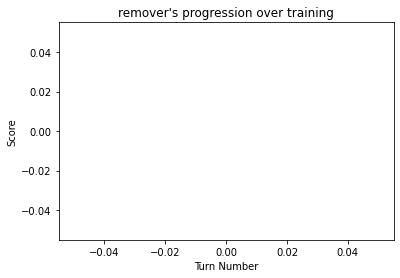

CURRENT SCORE: -1
Episode 0 Complete!
Episode 50 Complete!
Episode 100 Complete!


KeyboardInterrupt: 

In [17]:
models_path = 'models'
if not os.path.exists(models_path):
    os.makedirs('models')


device = torch.device("cpu")
K_interest = [4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2]
N_interest = [3, 4, 6, 7, 8, 9, 10, 6, 7, 8, 9, 10]

csv_path = 'master_table.csv'
if not os.path.exists(csv_path):
    column_names = ['K', 'N', 'Best Pusher Score']
    df = pd.DataFrame(columns=column_names)
    df.to_csv('master_table.csv', index=False)
    




for a in range(len(N_interest)):
    global subset_graph
    global num_graph
    VERSION = 2
    N = N_interest[a]
    K = K_interest[a]
    subset_graph = {}
    num_graph = {}
    index = 0
    values = [i for i in range(N * K)]
    for i in range(len(values) + 1):
        for subset in itertools.combinations(values, i):
            subset_graph[index] = subset
            num_graph[tuple(subset)] = index
            index += 1
    converged = False
    turn = "remover"
    past_scores = []
    while not converged:
        first_training = not (os.path.exists(f"models/model{N}{K}v{VERSION}Remover.pth") and os.path.exists(f"models/model{N}{K}v{VERSION}Pusher.pth"))
        BATCH_SIZE = 128
        GAMMA = 0.99
        EPS_START = 0.9
        EPS_END = 0.05
        EPS_DECAY = 1000
        num_episodes = 1000
        steps_done = 1
        if not first_training:
            EPS_DECAY = 1
            num_episodes = 100
        TAU = 0.005
        LR = 1e-4
        pusher_net = None
        remover_net = None
        state = Board(N, K)
        policy_net = -1
        target_net = -1
        if turn == "remover":
            nr_observations = 2 + 2 * (N * K)#N, K, the level of each chip, and whether each chip was selected
            nr_actions = N
            policy_net = Remover_DQN(nr_observations, nr_actions).to(device)
            if not first_training:
                policy_net = torch.load(f"models/model{N}{K}v{VERSION}Remover.pth")
                pusher_net = torch.load(f"models/model{N}{K}v{VERSION}Pusher.pth")
                remover_net = torch.load(f"models/model{N}{K}v{VERSION}Remover.pth")
            target_net = Remover_DQN(nr_observations, nr_actions).to(device)
            target_net.load_state_dict(policy_net.state_dict())
        if turn == "pusher":
            nr_observations = 2 + 1 * (N * K)#N, K, the level of each chip, and whether each chip was selected
            nr_actions = pow(2, N*K)
            policy_net = Pusher_DQN(nr_observations, nr_actions).to(device)
            if not first_training:
                policy_net = torch.load(f"models/model{N}{K}v{VERSION}Pusher.pth")
                pusher_net = torch.load(f"models/model{N}{K}v{VERSION}Pusher.pth")
                remover_net = torch.load(f"models/model{N}{K}v{VERSION}Remover.pth")
            target_net = Pusher_DQN(nr_observations, nr_actions).to(device)
            target_net.load_state_dict(policy_net.state_dict())

        optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
        memory = ReplayMemory(1000)


        if turn == "remover":
            board_scores = []
            for i_episode in range(num_episodes):
                # Initialize the environment and get its state
                state = Board(N, K)
                state = make_move_pusher(state, pusher_net, .1)
                #state = torch.tensor(board_to_remover(board), dtype=torch.float32, device=device)
                for t in count():
                    state_inp = torch.tensor(board_to_remover(state), device=device, dtype=torch.float32)
                    action, poss = select_action_remover(state, policy_net, EPS_START, EPS_END, EPS_DECAY, steps_done)
                    state = make_move_remover_action(state, action)
                    reward = state.score_board(True)
                    done = state.game_over()

                    next_state_inp = None
                    next_state_poss = None
                    if not done:
                        state = make_move_pusher(state, pusher_net, 0)
                        next_state_inp = torch.tensor(board_to_remover(state), device=device, dtype=torch.float32)
                        _, next_state_poss = select_action_remover(state, policy_net, EPS_START, EPS_END, EPS_DECAY, steps_done)

                    reward = torch.tensor([reward], device=device)
                    memory.push(state_inp, action, next_state_inp, reward, poss, next_state_poss)


                    optimize_model(policy_net, target_net, optimizer, memory)
                    target_net_state_dict = target_net.state_dict()
                    policy_net_state_dict = policy_net.state_dict()
                    for key in policy_net_state_dict:
                        target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                    target_net.load_state_dict(target_net_state_dict)
                    if done:
                        if i_episode % 5 == 0 and not first_training:
                            score = sim_game_no_print(N, K, pusher_net, policy_net)
                            board_scores.append(score)
                        break
                CHANGE = 7
                if len(board_scores) >= CHANGE:
                    last = board_scores[-CHANGE:]
                    if len(set(last)) == 1:
                        break
                if i_episode % 50 == 0:
                    print(f"Episode {i_episode} Complete!")
            print(f"{turn} Complete on Episode {i_episode}")
            plt.plot(board_scores)
            plt.title(f"{turn}'s progression over training")
            plt.xlabel("Turn Number")
            plt.ylabel("Score")
            plt.show()
        elif turn == "pusher":
            board_scores = []
            for i_episode in range(num_episodes):
                # Initialize the environment and get its state
                state = Board(N, K)
                #state = torch.tensor(board_to_remover(board), dtype=torch.float32, device=device)
                for t in count():
                    state_inp = torch.tensor(board_to_pusher(state), device=device, dtype=torch.float32)
                    action, poss = select_action_pusher(state, policy_net, EPS_START, EPS_END, EPS_DECAY, steps_done)
                    state = make_move_pusher_action(state, int(action))
                    state = make_move_remover(state, remover_net, 0)
                    done = state.game_over()
                    reward = state.score_board(False) #isPusher
                    reward = torch.tensor([reward], device=device)

                    next_state_inp = None
                    next_state_poss = None
                    if not done:
                        next_state_inp = torch.tensor(board_to_pusher(state), device=device, dtype=torch.float32)
                        _, next_state_poss = select_action_pusher(state, policy_net, EPS_START, EPS_END, EPS_DECAY, steps_done)

                    memory.push(state_inp, action, next_state_inp, reward, poss, next_state_poss)

                    optimize_model(policy_net, target_net, optimizer, memory)

                    target_net_state_dict = target_net.state_dict()
                    policy_net_state_dict = policy_net.state_dict()
                    for key in policy_net_state_dict:
                        target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                    target_net.load_state_dict(target_net_state_dict)
                    if done:
                        if i_episode % 5 == 0 and not first_training:
                            score = sim_game_no_print(N, K, policy_net, remover_net)
                            board_scores.append(score)
                        break
                CHANGE = 7
                if len(board_scores) >= CHANGE:
                    last = board_scores[-CHANGE:]
                    if len(set(last)) == 1:
                        break
                if i_episode % 50 == 0:
                    print(f"Episode {i_episode} Complete!")
            print(f"{turn} Complete on Episode {i_episode}")
            plt.plot(board_scores)
            plt.title(f"{turn}'s progression over training")
            plt.xlabel("Turn Number")
            plt.ylabel("Score")
            plt.show()
            print(f"{turn} Complete")
        if turn == "remover":
            torch.save(policy_net, f"models/model{N}{K}v{VERSION}Remover.pth")
        elif turn == "pusher":
            torch.save(policy_net, f"models/model{N}{K}v{VERSION}Pusher.pth")
        if first_training:
            past_scores.append(-1)
        else:
            score = -1
            if turn == "remover":
                score = sim_game(N, K, pusher_net, policy_net)
            elif turn == "pusher":
                score = sim_game(N, K, policy_net, remover_net)
            past_scores.append(score)
        CONVERGE_FACTOR = 5
        if len(past_scores) > CONVERGE_FACTOR + 1:
            temp = past_scores[-1]
            should_converge = True
            for i in range(CONVERGE_FACTOR - 1):
                if temp != past_scores[-2 - i]:
                    should_converge = False
                    break
            converged = should_converge
        print(f"CURRENT SCORE: {past_scores[-1]}")
        if turn == "remover":
            turn = "pusher"
        else:
            turn = "remover"
    pusher_net = torch.load(f"models/model{N}{K}v{VERSION}Pusher.pth")
    remover_net = torch.load(f"models/model{N}{K}v{VERSION}Remover.pth")
    score = sim_game(N, K, pusher_net, remover_net)
    df = pd.read_csv("master_table.csv")
    new_entry = {'K': K, 'N': N, 'Best Pusher Score': score}
    df = pd.concat([df, pd.DataFrame([new_entry])], ignore_index=True)
    print(f"N: {N}, K: {K}, Score: {score}")
    df.to_csv('master_table.csv', index=False)

In [ ]:
df = pd.read_csv("master_table.csv")
new_entry = {'K': 1, 'N': 1, 'Best Pusher Score': 1}
df = pd.concat([df, pd.DataFrame([new_entry])], ignore_index=True)
print(f"N: {N}, K: {K}, Score: {score}")
df.to_csv('master_table.csv', index=False)

In [ ]:
#Ideas for improvement:
'''
- for pusher combining equivalent moves into one possibility
'''

In [ ]:
state = Board(3, 3)

In [ ]:
'''

'''

In [16]:
VERSION = 2
N = 2
K = 4
pusher_net = torch.load(f"models/model{N}{K}v{VERSION}Pusher.pth")
remover_net = torch.load(f"models/model{N}{K}v{VERSION}Remover.pth")
score = sim_game(N, K, pusher_net, remover_net)

Pusher's move: 
Level 0: [[1, 1], [0, 0], [0, 0], [0, 0]]
Level 1: [[1, 1], [0, 0], [0, 0], [0, 0]]

Remover's move: 
Level 0: [[1, 0], [0, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [0, 0], [0, 0], [0, 0]]


Pusher's move: 
Level 0: [[2, 1], [1, 1], [0, 0], [0, 0]]
Level 1: [[-1, 0], [1, 1], [1, 1], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [0, 0], [0, 0]]
Level 1: [[-1, 0], [1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [1, 1], [0, 0]]
Level 1: [[-1, 0], [2, 1], [1, 0], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [1, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [1, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [2, 1], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [2, 1], [0, 0]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [2, 0], [0, 0]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [0, 0]]


Pusher's move: 
Level 0: [[-1, 0], [-1, 0], [3, 1], [1, 1]]
Level 1: [[-1, 0], [-1, 0], [-1, 0], [1, 1]]

Remover's move: 
Level 0: [[-1, 0], [-1, 0], [-1, 0], [-1